понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

# Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

# Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

# Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

# CNN для обработки текстов



In [1]:
#!pip install torchmetrics

In [2]:
#!pip install ipdb

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

### Слова



### Скачивание и подготовка данных

In [5]:
import wget
#wget.download("https://drive.google.com/uc?export=download&id=1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5")

In [146]:
type_dict = {1:1, -1:0}

In [147]:
positive = pd.read_csv('positive.csv', encoding='utf-8', sep=';', usecols=[3,4], names=['text', 'type'])
negative = pd.read_csv('negative.csv', encoding='utf-8', sep=';', usecols=[3,4], names=['text', 'type'])
data = pd.concat([positive, negative])
data['type'] = [type_dict[i] for i in data['type']]
data.drop_duplicates(inplace=True)

In [148]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=True)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [149]:
train_data[train_data.type == 1].shape[0] / train_data.shape[0]

0.5075595566593083

In [150]:
train_data.head(50)

,text,type
0,Карманная Катяя)\nТы знаешь что делать...\nИде...,1
1,Скоро это чудо будет моей:*** http://t.co/iRWH...,1
2,@ronniemustdie ну из своего города я только па...,0
3,@AsikLR не печалься:3 держи Томушку;)) http://...,1
4,@tutby так я ж не видел факт публикования ваши...,1
5,@Elya_Mangusheva @VorontsovaAnya @Igor995 она...,1
6,"@SatanLovesFangs а люди в ВК пишут, что это ре...",0
7,"@Vika_Tweet круто повезло, что она выиграла фо...",1
8,RT @Tatyana_98_: Эта картинка Ларри раздирает ...,0
9,@HORAN_NlALL И тут я запутался авхазхзвахазхзв...,1


Ну что ж... Где-то здесь должен возникнуть препроцессинг, и он возникнет

In [42]:
#!python -m spacy download ru_core_news_sm
import spacy
from tqdm import tqdm
nlp = spacy.load("ru_core_news_sm")

In [189]:
import re
def preprocess(text, nlp):
    #doc = nlp(text)
    #postags_stop = ['ADP', 'AUX', 'CCONJ', 'DET', 'INTJ', 'PART', 'PRON', 'PUNCT', 'SCONJ']
    lemms = []
    doc = re.split('[ \n\t,.]', text)
    #print(doc)
    for word in doc:
        if word:
            lemms.append(word.strip('#,.*\'\"@!?-^$:;').rstrip('():***').lower())
        #lemms.append(word.lemma_.lower())
    return ' '.join(lemms)

In [190]:
preprocess('@GREENloshadka уиии, круто)\nбеларусь, минск\n...	', nlp)

'greenloshadka уиии круто беларусь минск'

Теперь нам нужно попрепроцессить тексты. Или оставить пока так

Почему мы можем трогать только train_data? Потому что иначе может попасть что-нибудь из теста. Вероятно, будет не очень заментно, но исключать возможность не стоит, и на уровне слов она больше, чем на уровне символов

In [191]:
texts_of_lemms = []
vocab = Counter()
for text in tqdm(train_data['text']):
    lemma_text = preprocess(text, nlp)
    vocab.update(lemma_text.split(' '))
    texts_of_lemms = []
print('всего уникальных слов:', len(vocab))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173952/173952 [00:02<00:00, 85666.12it/s]

всего уникальных слов: 290892


In [63]:
vocab

Counter({'только': 2709,
         'прийти': 640,
         'домой': 484,
         ')': 42209,
         '\n': 13409,
         'завтра': 1472,
         'буду': 1272,
         'спать': 1057,
         'до': 1518,
         'час': 836,
         '10': 329,
         'точно': 355,
         'этот': 2858,
         'фотография': 119,
         'больше': 947,
         'год': 1934,
         'http://t.co/iwplejdinn': 1,
         'rt': 10016,
         '@das_patrick': 1,
         ':': 14644,
         'диана': 9,
         'ждёт': 11,
         'меня': 6368,
         ',': 54123,
         'пока': 652,
         'я': 18954,
         'у': 6444,
         'стоматолог': 28,
         ';': 1566,
         '(': 44061,
         '@blackbird_al': 1,
         'ахахаха': 137,
         'а': 10019,
         'почему': 1127,
         'училка': 38,
         'так': 5530,
         'написать': 611,
         '?': 9252,
         'она': 1365,
         'в': 16325,
         'тема': 197,
         '@kgshel': 1,
         'и': 17377,
     

In [192]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_vocab))

уникальных слов, встретившихся больше 5 раз: 24257


In [193]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for symbol in filtered_vocab:
    word2id[symbol] = len(word2id)

In [194]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [195]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### Dataset & DataLoader

In [196]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[word.lower()] for word in words if word.lower() in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

### создаем итераторы по данным для трейна и теста

In [197]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [198]:
batch = next(iter(train_iterator))

In [199]:
batch[0].shape

torch.Size([64, 18])

In [200]:
[id2word[int(i)] for i in batch[0][0]]

['надо',
 'бы',
 'перестать',
 'лениться',
 'одевать',
 'ремень',
 'на',
 'штаны',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [202]:
batch[1]

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]], device='cuda:0')

In [204]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [205]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([64, 21])

### CNN model

In [206]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

tensor([[[-0.3758,  0.5386,  0.6521, -0.4415],
         [-0.7028, -0.1305, -0.5057,  0.0310],
         [-0.7509, -2.1625, -0.2247,  0.9128],
         [-1.2174, -1.6512,  0.0316,  1.0966],
         [-0.8049,  0.5391,  0.7198, -0.0848],
         [ 1.8776,  2.1683,  1.2538,  0.5440],
         [ 0.0085, -0.1087,  1.5129, -0.5891],
         [-1.3509, -0.3874,  1.1731,  0.2464]],

        [[ 0.1856, -1.4954,  0.5557,  1.5093],
         [-0.8962, -0.3355, -0.6238,  0.5596],
         [-0.6386, -1.0572,  1.9130, -0.3563],
         [ 1.1571, -1.6483, -0.4471, -1.2205],
         [-0.1934, -0.1949, -0.5082, -0.5347],
         [-0.1518,  0.1906, -0.5117,  0.1265],
         [ 0.1161,  0.7506, -0.0486, -0.3525],
         [ 1.2139, -1.4054,  1.0630,  0.3576]],

        [[-0.8484,  0.0110,  0.0082,  1.3653],
         [-0.1811,  0.0562, -0.2274,  0.2589],
         [ 0.9427, -0.5422, -0.6181,  1.1976],
         [ 0.2369,  0.2588,  0.8247, -0.3301],
         [-1.3810,  0.8723,  0.3113,  0.4015],
         

In [207]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

torch.Size([3, 8, 2])


tensor([[[ 0.5386,  0.6521],
         [-0.1305,  0.0310],
         [-0.7509,  0.9128],
         [-1.2174,  1.0966],
         [ 0.5391,  0.7198],
         [ 2.1683,  1.2538],
         [ 0.0085,  1.5129],
         [-0.3874,  1.1731]],

        [[ 0.1856,  1.5093],
         [-0.3355,  0.5596],
         [-0.6386,  1.9130],
         [ 1.1571, -0.4471],
         [-0.1934, -0.5082],
         [ 0.1906,  0.1265],
         [ 0.7506, -0.0486],
         [ 1.2139,  1.0630]],

        [[ 0.0110,  1.3653],
         [ 0.0562,  0.2589],
         [ 0.9427,  1.1976],
         [ 0.2588,  0.8247],
         [ 0.8723,  0.4015],
         [ 0.5827,  2.9218],
         [-0.4633, -0.3906],
         [-0.5573,  0.2154]]])

In [208]:
fm.max(2)[0]

tensor([[ 0.6521,  0.0310,  0.9128,  1.0966,  0.7198,  2.1683,  1.5129,  1.1731],
        [ 1.5093,  0.5596,  1.9130,  1.1571, -0.1934,  0.1906,  0.7506,  1.2139],
        [ 1.3653,  0.2589,  1.1976,  0.8247,  0.8723,  2.9218, -0.3906,  0.2154]])

In [209]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concat_bigrams = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        #self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        #self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        #feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        #feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        # batch_size x filter_count3 x seq_len*
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        #pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        #pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        feature_map_concat = self.relu(self.concat_bigrams(concat))
        pooling = feature_map_concat.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling)
        logits = self.out(logits)
        
        return logits

In [210]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[23932, 22433,  4569,  ...,     0,     0,     0],
        [ 9701, 23825, 23994,  ...,     0,     0,     0],
        [15987, 21681, 13883,  ...,     0,     0,     0],
        ...,
        [ 1182,  4899,  7538,  ...,     0,     0,     0],
        [10795, 23083, 19601,  ...,     0,     0,     0],
        [22433, 16156, 12510,  ...,     0,     0,     0]])


In [211]:
print(batch)

tensor([[23932, 22433,  4569,  ...,     0,     0,     0],
        [ 9701, 23825, 23994,  ...,     0,     0,     0],
        [15987, 21681, 13883,  ...,     0,     0,     0],
        ...,
        [ 1182,  4899,  7538,  ...,     0,     0,     0],
        [10795, 23083, 19601,  ...,     0,     0,     0],
        [22433, 16156, 12510,  ...,     0,     0,     0]])


In [212]:
y

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]])

In [213]:
model = CNN(len(id2word), 64)
output = model(batch)
print(output)

tensor([[0.4779],
        [0.4804],
        [0.4916],
        [0.4732],
        [0.4773],
        [0.4720],
        [0.4712],
        [0.4824],
        [0.4654],
        [0.4700],
        [0.4786],
        [0.4701],
        [0.4787],
        [0.4676],
        [0.4640],
        [0.4858],
        [0.4889],
        [0.4817],
        [0.4810],
        [0.4859],
        [0.4617],
        [0.4587],
        [0.5062],
        [0.4630],
        [0.4867],
        [0.5022],
        [0.4781],
        [0.4727],
        [0.4823],
        [0.4772],
        [0.4818],
        [0.4790],
        [0.4877],
        [0.4817],
        [0.4588],
        [0.4920],
        [0.4981],
        [0.4795],
        [0.4831],
        [0.4802],
        [0.4645],
        [0.4805],
        [0.4938],
        [0.4624],
        [0.4641],
        [0.4721],
        [0.4698],
        [0.4552],
        [0.4921],
        [0.4669],
        [0.5022],
        [0.4781],
        [0.4667],
        [0.4669],
        [0.4712],
        [0

In [214]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.6879, grad_fn=<BinaryCrossEntropyBackward0>)

In [215]:
f1(output, y.long())

tensor(0.2286)

### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [216]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [217]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### инициализируем модель, задаем оптимизатор и функцию потерь

In [218]:
model = CNN(len(word2id), 64)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### запуск обучения!

In [221]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(50):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.5863362121296105
Train loss: 0.5862874459011763
Train loss: 0.5864428120507362
Train loss: 0.5851654145147657
Train loss: 0.5845411649809749

Evaluating on train...
Val loss: 0.5446375540811638, Val f1: 0.7308131456375122
Val loss: 0.5448338473996809, Val f1: 0.7295262217521667
Val loss: 0.5460332598747727, Val f1: 0.7285375595092773
Val loss: 0.5456135751381825, Val f1: 0.727861762046814
Val loss: 0.5459026695286077, Val f1: 0.7277320623397827

Evaluating on test...
Val loss: 0.6014044724128864, Val f1: 0.674317479133606
Val loss: 0.5990889935695817, Val f1: 0.6761571764945984
Val loss: 0.5987235719946737, Val f1: 0.675381064414978
Val loss: 0.5998692731501648, Val f1: 0.6736787557601929
Val loss: 0.6000124617686855, Val f1: 0.6718292832374573

starting Epoch 1
Training...
Train loss: 0.5474280430162085
Train loss: 0.549624158270348
Train loss: 0.5503673835563718
Train loss: 0.5488493047184463
Train loss: 0.5487719936764407

Evaluating on tr

Val loss: 0.1715174111987832, Val f1: 0.9368208050727844
Val loss: 0.17127656976473496, Val f1: 0.9354495406150818
Val loss: 0.1704082389245455, Val f1: 0.9358892440795898
Val loss: 0.17089399699514662, Val f1: 0.9351230263710022
Val loss: 0.17133508427459787, Val f1: 0.9347357749938965

Evaluating on test...
Val loss: 0.9867222501171959, Val f1: 0.6724744439125061
Val loss: 0.9865940377061218, Val f1: 0.6624783277511597
Val loss: 0.9859158103091125, Val f1: 0.6600662469863892
Val loss: 0.9958581334429332, Val f1: 0.661040723323822
Val loss: 0.9987083217444581, Val f1: 0.6589279174804688

starting Epoch 11
Training...
Train loss: 0.1759891380243196
Train loss: 0.18092926192668177
Train loss: 0.18685859507659144
Train loss: 0.19242905476012576
Train loss: 0.19693493760995945

Evaluating on train...
Val loss: 0.15634765133701567, Val f1: 0.9423356652259827
Val loss: 0.1569295764656111, Val f1: 0.9412312507629395
Val loss: 0.1572877761955929, Val f1: 0.940460205078125
Val loss: 0.15717783

Val loss: 0.05938398563337377, Val f1: 0.9761346578598022
Val loss: 0.05995616609833788, Val f1: 0.9757260084152222
Val loss: 0.06029490250531329, Val f1: 0.9755194187164307

Evaluating on test...
Val loss: 2.512988694950386, Val f1: 0.6735525131225586
Val loss: 2.5429796400545266, Val f1: 0.6629979014396667
Val loss: 2.5449136756269, Val f1: 0.6600173711776733
Val loss: 2.5287845100706674, Val f1: 0.6598820686340332
Val loss: 2.4957514287621354, Val f1: 0.6587596535682678

starting Epoch 21
Training...
Train loss: 0.059691299537430444
Train loss: 0.06091842599007116
Train loss: 0.06379504661483082
Train loss: 0.06807063967212588
Train loss: 0.07046966953855077

Evaluating on train...
Val loss: 0.05281774062024106, Val f1: 0.9796361327171326
Val loss: 0.053371453497018065, Val f1: 0.9779148697853088
Val loss: 0.05296739960602469, Val f1: 0.9773098230361938
Val loss: 0.05339410153748695, Val f1: 0.9770262241363525
Val loss: 0.05331162385355651, Val f1: 0.9771751165390015

Evaluating on 

Val loss: 0.04868147928995549, Val f1: 0.9782818555831909

Evaluating on test...
Val loss: 3.574899710107733, Val f1: 0.6359406113624573
Val loss: 3.7040185147545874, Val f1: 0.6298350691795349
Val loss: 3.7094109332239307, Val f1: 0.6279236674308777
Val loss: 3.7363431353814915, Val f1: 0.6292805671691895
Val loss: 3.738591043780584, Val f1: 0.6286226511001587

starting Epoch 31
Training...
Train loss: 0.04148168380675508
Train loss: 0.04329653475734015
Train loss: 0.04661381127428909
Train loss: 0.048906091162021166
Train loss: 0.05031790626533851

Evaluating on train...
Val loss: 0.04042891387735765, Val f1: 0.982399046421051
Val loss: 0.04067737252450406, Val f1: 0.9811898469924927
Val loss: 0.04083743795971483, Val f1: 0.9811136722564697
Val loss: 0.04049721284724325, Val f1: 0.9813019037246704
Val loss: 0.04058888459516989, Val f1: 0.9812479019165039

Evaluating on test...
Val loss: 4.449512702447397, Val f1: 0.672086238861084
Val loss: 4.515717534561439, Val f1: 0.66407161951065

Val loss: 5.406999022978258, Val f1: 0.668300211429596
Val loss: 5.4583741158466665, Val f1: 0.6653535962104797
Val loss: 5.4589602460957805, Val f1: 0.6651381850242615
Val loss: 5.456626657797065, Val f1: 0.6640042066574097

starting Epoch 41
Training...
Train loss: 0.03462072047849557
Train loss: 0.037357884816973455
Train loss: 0.03866018316314066
Train loss: 0.039886612671646
Train loss: 0.0412446908779664

Evaluating on train...
Val loss: 0.0349692966195332, Val f1: 0.9850504398345947
Val loss: 0.03537707741998355, Val f1: 0.9845626950263977
Val loss: 0.035924665568992396, Val f1: 0.9839261174201965
Val loss: 0.03545725125428895, Val f1: 0.9840405583381653
Val loss: 0.03495219104017153, Val f1: 0.9843791723251343

Evaluating on test...
Val loss: 5.10895953796528, Val f1: 0.6555642485618591
Val loss: 5.091412399087885, Val f1: 0.6494653820991516
Val loss: 5.088722852289823, Val f1: 0.6468754410743713
Val loss: 5.082934791431462, Val f1: 0.6476203799247742
Val loss: 5.06262761679243

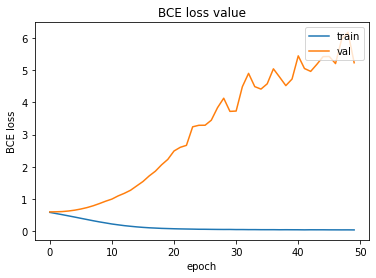

In [236]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

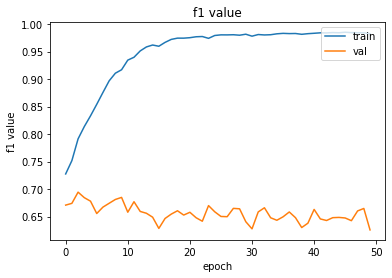

In [237]:
import matplotlib.pyplot as plt
plt.plot([i.cpu() for i in f1s])
plt.plot([i.cpu() for i in f1s_eval])
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Достаточно посмотреть на эти графики, чтобы понять очевидное -- мы переобучились! И нам придётся что-нибудь с этим делать

In [238]:
print('f1 c дропаутом и уменьшением lr и количества эпох')
print(f1s_eval[-1].item())
print('loss c дропаутом и уменьшением lr и количества эпох')
print(losses_eval[-1])

f1 c дропаутом и уменьшением lr и количества эпох
0.6257590651512146
loss c дропаутом и уменьшением lr и количества эпох
5.23437500157777


Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [228]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ''.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [229]:
fp, fn, tp, tn = predict(model, val_iterator)

In [239]:
def get_metrics(fp, fn, tp, tn):
    all_preds = len(fp) + len(fn) + len(tp) + len(tn)
    print('accuracy')
    print((len(tp) + len(tn))/all_preds)
    print('precision')
    print(len(tp)/(len(fp) + len(tp)))
    print('recall')
    print(len(tp)/(len(fn) + len(tp)))

In [240]:
get_metrics(fp, fn, tp, tn)

accuracy
0.641832229580574
precision
0.6634620199288969
recall
0.5994118977606876


In [230]:
print('что правильно предсказываем:', tp[:100])

что правильно предсказываем: ['даонионидумаличтомыиправдатакиенасамомтоделевсевсенормально', 'rtнезадаютэтобесплатныйсайтличноотебечтомы', 'rtедуввокругтакая', 'rtпозвонилавыздоравливай', 'недостаточноатемаобъяснилэточтоуменядрузьянепо', 'воченьнебольшойив', 'rtтакидедуанапочтеотдельныйящикраньшетак', 'поздравляювассднемделаюисполнения', 'rtспокойнойванв', 'ятолькохотелутебякактыпопалввсвободныйот', 'ябезумноусталазасегодняшниймоимроднымзаэтотвечер!', 'такбыисъел', 'ещенукакзато', 'какжеячтонекоторыелюдибылинамоемсулыбкой', 'сижуввдетскомтеатре—братдевушкииграетсразу2', 'дачтобктебепришел', 'rtтымнеяведьведусебякактебенравятсятольковтвоём', 'акаквышлидумалисбудетскучноинектонемыглубоко', 'когдабабушказаходитвавтобусвсявнезапно', 'собрал', 'какзафотовинстаграмспасибо', 'ивамтоженастроенияещё', 'завтраквпостель2ссыромичашкачерногочаялучшее', 'кпредыдущемууменяестьдрузьястакчтонаихужепримеремогу', 'rtсднембудешь', 'выкакаявыключаювнавсякиймалоли', 'янекогдатыговоришь//теперь', 'наувиделиу

In [231]:
print('ошибочно не относим к фамилиям:', fn[:100])

ошибочно не относим к фамилиям: ['меняужебеситтвоетупоесвоипринципыпрекратисратьвдушуатоубиратьзатобойбудеттолькотвоя', 'атокаквсечтонужноивточтоне', 'имя17минвкуснаякурица', 'какойсамыйкрутойзачет', 'нельзяживотнымахотелось', 'проспала15чувствуюсебясамымчеловекомна', '', 'ярешилазабитьнамодныесейчассериалыиначаласмотретьссамоготакподнимают', 'почемумолодымлюдямтакненравитсяженскаяобувь', 'rtнуещенеанастроениеуже', 'rtпотокскомпасмузыкойнааоттудачерезнаушникио_о', 'чтоэтозафотографии', 'есликвамсночевкоймногоивамнегдеихвозьмитепобольшеионисаминайдутсебе', 'насамомделеявшокес', 'менясилавзрывэмоций', 'чтояменявсегоипоканечтосигаретуменяпздц', 'утебяочэтоточно!', 'ядавнохотелимнонеполучитсялиачегонео_о', 'телефонненадо?а—ахахахах', 'оооообылоавбылилишь', 'ударвчелюстьзаменяет3часаэтопровмнетаклегче', 'забытьвыбывасхотябы', 'даточно', 'нущитонепросто', 'rtкрасиваялюблюпольшу', 'пиздецменяаааподпеснилюбимойнезряжзачеткаколятут', 'нувсезимниеканикулымнеспасибо', 'смотрюнаэтихдураковиузнаюна

In [232]:
print('ошибочно считаем фамилиями:', fp[:100])

ошибочно считаем фамилиями: ['rtвжопе', 'rtзабылаотметитьмойденьрождения29октября', 'янесигратормозитжутко—компне', 'rtnew–дрочунанее', 'ясебеоченьплохотакчтодавайлучшезавтрапойдемвсегулятьиятебетвой', 'теперьуменяестькрутаячтонемного', 'rtпочемутакойсерый—нравится', 'rtуменянапараллелитакаядевка', 'уменятакбарбиневернули', 'атакчтобывсёхорошо', 'яуедунакогдавырасту', 'rtвеликолепнаясериятолько', 'ятожеургантпро', 'почтине', 'ужемоскваспатьпошла', 'деньсвятоговсечтовсе', 'овоттебяитоприятнеемб', 'мнекупилиподарятеготолько29декабряждать15дней', 'пропустилнаминутунетеперьоколостоятьна', 'нунаучебехотяитыпосленгвсе-такиеще', 'надушемнепоможетивановнаиведроснимиибудет', 'япокастоювочередивбанкевсегдапомогаюотправитьпарунаниодинсотрудникбанкани', 'подарилинедавномненаодномдрнувеселаябылабез', 'сегодняпосмотрелднёмфильмнооченьинтереснаяреальная5из', 'чтокак/где/ненас', 'явообщепитьнадобыломеньше', 'да!какздоровоприйтиви38', 'напередчетыревсестоятвключая', 'толькочтоузналчтосегоднячто-то', 'ч